In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 5.4 MB/s 
     |████████████████████████████████| 727 kB 35.4 MB/s 
     |████████████████████████████████| 152 kB 43.5 MB/s 
     |████████████████████████████████| 245 kB 47.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 124 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.7 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Binary Polymer Solution Cloud Point Database.csv')
df['Polymer Mols'] = df['Polymer SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df['Solvent Mols'] = df['Solvent SMILES'].apply(lambda x : Chem.MolFromSmiles(x))
df = df.dropna(0)

<ipython-input-4-b1f5684ff214>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna(0)


In [5]:
df

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
0,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.12780,0.1202,4.73,-3.97,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f902dcfcb30>,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12b30>
1,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.17425,0.1644,4.44,-4.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f902dca85f0>,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12c10>
2,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],27200,1.03,0.19746,0.1866,0.48,-3.87,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f902dca8270>,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12ba0>
3,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,propionitrile,107-12-0,CCC#N,26700,1.05,0.09173,0.1100,2.28,172.28,negative,doi.org/10.1021/ma9517308,<rdkit.Chem.rdchem.Mol object at 0x7f902dca8660>,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12c80>
4,polystyrene-d8,27732-42-9,[2H]C([2H])(*)C(*)([2H])c1c([2H])c([2H])c([2H]...,nitroethane,79-24-3,CC[N+](=O)[O-],85200,1.02,0.11958,0.1124,0.25,14.99,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f902dca86d0>,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12cf0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.5056,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12820>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dc80>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.1159,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12890>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dcf0>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.1394,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12900>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dd60>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.4083,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12970>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4ddd0>


In [6]:
#Remove rows with polyetyrene-d8 (includes deuterium)
index_d_droped = df[(df["Polymer"] == "polystyrene-d8") | (df["Solvent"] == "nitroethane-d5")].index
df_new = df.drop(index_d_droped)
df_new

,Polymer,Polymer CAS,Polymer SMILES,Solvent,Solvent CAS,Solvent SMILES,Mw(Da),PDI,ϕ,w,P(Mpa),CP(°C),1-Phase,Ref.,Polymer Mols,Solvent Mols
395,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.11406,0.15000,82.81,21.34,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f902dc674a0>,<rdkit.Chem.rdchem.Mol object at 0x7f902dba1ac0>
396,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclohexane,108-87-2,CC1CCCCC1,17500,1.06,0.18196,0.23366,80.00,21.18,positive,doi.org/10.1002/macp.1994.021950233,<rdkit.Chem.rdchem.Mol object at 0x7f902dc67510>,<rdkit.Chem.rdchem.Mol object at 0x7f902dba1b30>
397,polystyrene,9003-53-6,*C(C*)c1ccccc1,cyclohexanol,108-93-0,OC1CCCCC1,78800,1.12,0.00632,0.00700,0.10,73.99,positive,doi.org/10.1021/je0504865,<rdkit.Chem.rdchem.Mol object at 0x7f902dc67580>,<rdkit.Chem.rdchem.Mol object at 0x7f902dba1ba0>
398,polystyrene,9003-53-6,*C(C*)c1ccccc1,methylcyclopentane,96-37-7,CC1CCCC1,22100,1.03,0.11401,0.15300,1.02,27.42,positive,doi.org/10.1021/ma00107a011,<rdkit.Chem.rdchem.Mol object at 0x7f902dc675f0>,<rdkit.Chem.rdchem.Mol object at 0x7f902dba1c10>
399,polystyrene,9003-53-6,*C(C*)c1ccccc1,nitroethane,79-24-3,CC[N+](=O)[O-],13500,1.06,0.17990,0.17990,4.35,6.08,positive,doi.org/10.1006/jcht.1999.0607,<rdkit.Chem.rdchem.Mol object at 0x7f902dc67660>,<rdkit.Chem.rdchem.Mol object at 0x7f902dba1c80>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6519,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.44220,0.50560,0.10,63.14,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12820>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dc80>
6520,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.09225,0.11590,0.10,71.08,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12890>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dcf0>
6521,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.11156,0.13940,0.10,72.63,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12900>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4dd60>
6522,"poly(1,3-dioxolane)",25067-64-5,*OCOCC*,water,7732-18-5,O,50000,1.50,0.34850,0.40830,0.10,73.50,negative,doi.org/10.1021/ma00047a022,<rdkit.Chem.rdchem.Mol object at 0x7f902dc12970>,<rdkit.Chem.rdchem.Mol object at 0x7f902db4ddd0>


# **Descriptor Calculation**

In [7]:
class Morgan_fingerprint(): #From Chen

    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return
    
    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]: 
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()
            
        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, 
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol
                
        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type       
        return pd.DataFrame.from_dict(morgan_count)

    def visualize(self,bit_name,molSize=(250,200),verbose=True):
        bitId = int(bit_name)
        if verbose==True: print ('bit %s'%bitId)
        zid = self.bitExamples[bitId]
        mol = self.keepMols[zid]
        aid,rad = self.bitI_morgan[zid][bitId][0]
        pic1,svg  = getSubstructDepiction(mol,aid,rad,molSize=molSize)
        pic2 = Draw.DrawMorganBit(mol,bitId,self.bitI_morgan[zid])
        #display(pic)
        return pic1,pic2,svg

#for visualization #From Chen
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    #with open('morgan bits/%s.svg'%bitId, 'w') as f:
    #    f.write(svg)
    return SVG(svg.replace('svg:','')),svg 

def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse)

In [8]:
#MF for polymer
mf_poly = Morgan_fingerprint(df_new["Polymer Mols"].values)
fp_poly = mf_poly.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_poly = fp_poly.dropna(1)

#MF for solvent
mf_sol = Morgan_fingerprint(df_new["Solvent Mols"].values)
fp_sol = mf_sol.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
fp_sol = fp_sol.dropna(1)

100%|██████████| 4833/4833 [00:00<00:00, 5711.23it/s]
<ipython-input-8-875bed0b3429>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_poly = fp_poly.dropna(1)
100%|██████████| 4833/4833 [00:00<00:00, 8894.39it/s]
<ipython-input-8-875bed0b3429>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  fp_sol = fp_sol.dropna(1)


In [9]:
fp_poly.head()

,1,64,80,170,175,226,247,341,356,389,...,566,587,863,875,103,578,658,770,932,968
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
fp_sol.head()

,2,4,33,117,124,285,301,890,926,973,...,512,781,831,378,656,777,386,799,896,709
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Descriptor Combination (Poly_MF/Sol_MF)**

In [11]:
fp_sol.columns

Index(['2', '4', '33', '117', '124', '285', '301', '890', '926', '973',
       ...
       '512', '781', '831', '378', '656', '777', '386', '799', '896', '709'],
      dtype='object', length=173)

In [12]:
fp_sol_new = fp_sol.rename(columns=lambda n: n + '*')

In [13]:
fp_sol_new

,2*,4*,33*,117*,124*,285*,301*,890*,926*,973*,...,512*,781*,831*,378*,656*,777*,386*,799*,896*,709*
0,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1,2,1,1,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,2,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,2,1,1,2,2,4,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
fp_com_mf = pd.concat([fp_poly, fp_sol_new, df_new.reset_index(drop=True)[["Mw(Da)", "PDI", "ϕ", "w", "P(Mpa)", "1-Phase", "CP(°C)"]]], axis=1)
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,negative,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,negative,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,negative,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,negative,73.50


In [15]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(fp_com_mf["1-Phase"])

fp_com_mf["1-Phase"] = LE.fit_transform(fp_com_mf["1-Phase"])
fp_com_mf

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


Feature scaling

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = fp_com_mf.copy()
f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]] = scaler.fit_transform(f_std.loc[:, ["Mw(Da)", "P(Mpa)", "CP(°C)"]])

In [17]:
f_std.head()

,1,64,80,170,175,226,247,341,356,389,...,799*,896*,709*,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.531646,1.06,0.11406,0.15000,5.774263,1,-0.763116
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.531646,1.06,0.18196,0.23366,5.564014,1,-0.765189
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.323328,1.12,0.00632,0.00700,-0.414228,1,-0.080926
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.516014,1.03,0.11401,0.15300,-0.345393,1,-0.684337
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,-0.545239,1.06,0.17990,0.17990,-0.096237,1,-0.960841


In [18]:
f_phase0 = f_std[f_std["1-Phase"]==0]
f_phase1 = f_std[f_std["1-Phase"]==1]

# **Model Building**

In [19]:
from sklearn.model_selection import train_test_split

X_0 = f_phase0.iloc[:, :-1].values
y_0 = f_phase0.iloc[:, -1].values
X_1 = f_phase1.iloc[:, :-1].values
y_1 = f_phase1.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=5)

In [20]:
# A list for the evaluation result
rmse_sum_0 = {}
rmse_sum_1 = {}
r2_sum_0 = {}
r2_sum_1 = {}

## Lasso

In [21]:
from sklearn.linear_model import Lasso

lasso_0 = Lasso(alpha=0.1)
lasso_1 = Lasso(alpha=0.1)

lasso_0.fit(X_train_0, y_train_0)
lasso_1.fit(X_train_1, y_train_1)

Lasso(alpha=0.1)

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, lasso_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, lasso_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, lasso_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, lasso_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, lasso_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, lasso_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, lasso_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, lasso_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.8341797320526294
RMSE(Train_0): 0.37814575431078895
R_square(Test_0): 0.8571757322010095
RMSE(Test_0): 0.35464424803863237

R_square(Train_1): 0.2076144248224725
RMSE(Train_1): 0.48921417905519293
R_square(Test_1): 0.21563753208791492
RMSE(Test_1): 0.5015112499208181


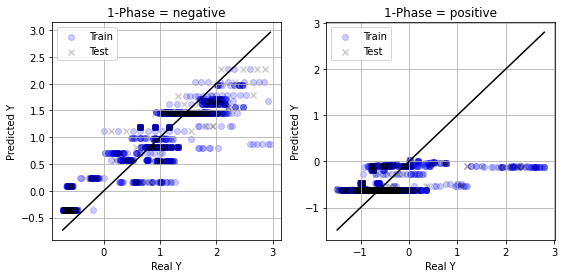

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, lasso_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, lasso_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, lasso_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, lasso_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [24]:
rmse_sum_0['Linear Regression(Lasso)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Lasso)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Lasso)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Lasso)'] = [R_square_train_1, R_square_test_1] 

## Ridge

In [25]:
from sklearn.linear_model import Ridge
ridge_0 = Ridge(alpha=0.1)
ridge_1 = Ridge(alpha=0.1)

ridge_0.fit(X_train_0, y_train_0)
ridge_1.fit(X_train_1, y_train_1)

Ridge(alpha=0.1)

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, ridge_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, ridge_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, ridge_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, ridge_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, ridge_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, ridge_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, ridge_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, ridge_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.957636376406263
RMSE(Train_0): 0.19113357045105356
R_square(Test_0): 0.9599938878933979
RMSE(Test_0): 0.18769603183124842

R_square(Train_1): 0.8345301885971044
RMSE(Train_1): 0.22355796174166193
R_square(Test_1): 0.820681949831616
RMSE(Test_1): 0.23979177439270713


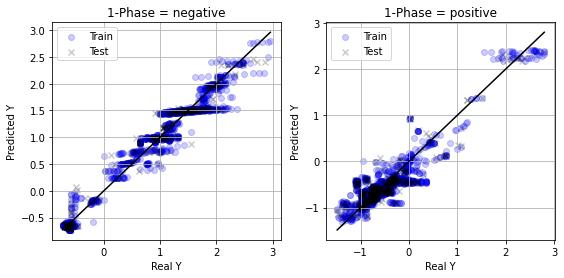

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, ridge_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, ridge_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, ridge_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, ridge_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [28]:
rmse_sum_0['Linear Regression(Ridge)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Ridge)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Ridge)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Ridge)'] = [R_square_train_1, R_square_test_1] 

## ElasticNet

In [29]:
from sklearn.linear_model import ElasticNet
EN_0 = ElasticNet(alpha=0.1)
EN_1 = ElasticNet(alpha=0.1)

EN_0.fit(X_train_0, y_train_0)
EN_1.fit(X_train_1, y_train_1)

ElasticNet(alpha=0.1)

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, EN_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, EN_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, EN_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, EN_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, EN_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, EN_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, EN_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, EN_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.8601705836156179
RMSE(Train_0): 0.3472479534654071
R_square(Test_0): 0.8785430789882391
RMSE(Test_0): 0.3270416392568786

R_square(Train_1): 0.3594921492367693
RMSE(Train_1): 0.4398382393458324
R_square(Test_1): 0.36591073357124515
RMSE(Test_1): 0.4509179026219713


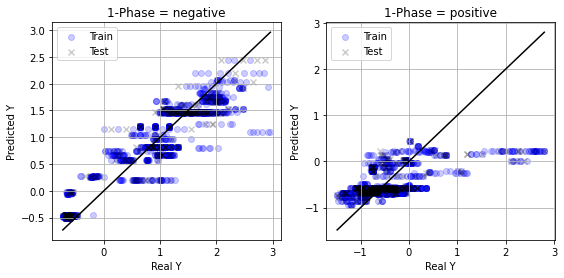

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, EN_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, EN_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, EN_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, EN_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [32]:
rmse_sum_0['Linear Regression(ElasticNet)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(ElasticNet)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(ElasticNet)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(ElasticNet)'] = [R_square_train_1, R_square_test_1] 

## RF

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_0 = RandomForestRegressor()
rf_1 = RandomForestRegressor()

rf_0.fit(X_train_0, y_train_0)
rf_1.fit(X_train_1, y_train_1)

RandomForestRegressor()

In [34]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_0, rf_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, rf_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, rf_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, rf_0.predict(X_test_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_1, rf_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, rf_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, rf_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, rf_1.predict(X_test_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}')

For 1-Phase = negative
R_square(Train): 0.999264786971641
RMSE(Train): 0.0251794952260236
R_square(Test): 0.9956270077855984
RMSE(Test): 0.06205564148094886

For 1-Phase = positive
R_square(Train): 0.9991459334308763
RMSE(Train): 0.016061149206020968
R_square(Test): 0.9919174088651453
RMSE(Test): 0.05090935356579998


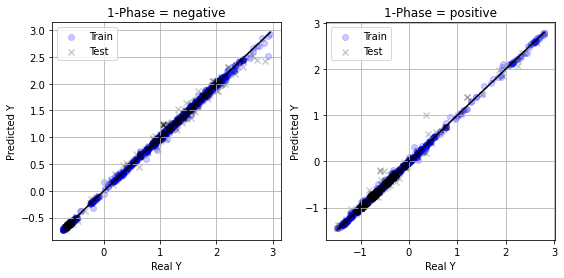

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, rf_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, rf_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, rf_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, rf_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [36]:
rmse_sum_0['RF'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['RF'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['RF'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['RF'] = [R_square_train_1, R_square_test_1] 

## SVR

In [37]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [38]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [39]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [40]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## XGB

In [41]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [42]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [43]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [44]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test] 
# r2_sum['XGBoost'] = [R_square_train, R_square_test] 

## GpyTorch

In [46]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm_0 = mmscaler.fit_transform(X_train_0)
X_test_mm_0 = mmscaler.transform(X_test_0)
X_train_mm_1 = mmscaler.fit_transform(X_train_1)
X_test_mm_1 = mmscaler.transform(X_test_1)

X_train_tensor_0 = torch.from_numpy(np.array(X_train_mm_0))
X_test_tensor_0 = torch.from_numpy(np.array(X_test_mm_0))
X_train_tensor_1 = torch.from_numpy(np.array(X_train_mm_1))
X_test_tensor_1 = torch.from_numpy(np.array(X_test_mm_1))

# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s_0 = y_scaler.fit_transform(y_train_0.reshape(-1, 1))
y_test_s_0 = y_scaler.transform(y_test_0.reshape(-1, 1))
y_train_s_1 = y_scaler.fit_transform(y_train_1.reshape(-1, 1))
y_test_s_1 = y_scaler.transform(y_test_1.reshape(-1, 1))

y_train_tensor_0 = torch.from_numpy(np.array(y_train_s_0))
y_test_tensor_0 = torch.from_numpy(np.array(y_test_s_0))
y_train_tensor_1 = torch.from_numpy(np.array(y_train_s_1))
y_test_tensor_1 = torch.from_numpy(np.array(y_test_s_1))

In [47]:
kernel_0 = RBFKernel(ard_num_dims=X_0.shape[1])

gp_0 = SingleTaskGP(X_train_tensor_0, y_train_tensor_0, covar_module=kernel_0)
mll_0 = ExactMarginalLogLikelihood(gp_0.likelihood, gp_0)

fit_gpytorch_model(mll_0)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [48]:
kernel_1 = RBFKernel(ard_num_dims=X_1.shape[1])

gp_1 = SingleTaskGP(X_train_tensor_1, y_train_tensor_1, covar_module=kernel_1)
mll_1 = ExactMarginalLogLikelihood(gp_1.likelihood, gp_1)

fit_gpytorch_model(mll_1)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [ ]:
# import pickle

# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='wb') as f:
#   pickle.dump(gp,f)

In [ ]:
# import pickle
# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='rb') as m:
#   gp = pickle.load(m)

In [53]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred_0 = gp_0.posterior(X_train_tensor_0).mean.detach().numpy().copy()
y_train_var_0 = gp_0.posterior(X_train_tensor_0).variance.detach().numpy().copy()
y_train_pred_1 = gp_1.posterior(X_train_tensor_1).mean.detach().numpy().copy()
y_train_var_1 = gp_1.posterior(X_train_tensor_1).variance.detach().numpy().copy()

y_test_pred_0 = gp_0.posterior(X_test_tensor_0).mean.detach().numpy().copy()
y_test_var_0 = gp_0.posterior(X_test_tensor_0).variance.detach().numpy().copy()
y_test_pred_1 = gp_1.posterior(X_test_tensor_1).mean.detach().numpy().copy()
y_test_var_1 = gp_1.posterior(X_test_tensor_1).variance.detach().numpy().copy()

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_s_0, y_train_pred_0)
RMSE_train_0 = mean_squared_error(y_scaler.inverse_transform(y_train_s_0), y_scaler.inverse_transform(y_train_pred_0), squared=False)
R_square_test_0 = r2_score(y_test_s_0, y_test_pred_0)
RMSE_test_0 = mean_squared_error(y_scaler.inverse_transform(y_test_s_0), y_scaler.inverse_transform(y_test_pred_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_s_1, y_train_pred_1)
RMSE_train_1 = mean_squared_error(y_scaler.inverse_transform(y_train_s_1), y_scaler.inverse_transform(y_train_pred_1), squared=False)
R_square_test_1 = r2_score(y_test_s_1, y_test_pred_1)
RMSE_test_1 = mean_squared_error(y_scaler.inverse_transform(y_test_s_1), y_scaler.inverse_transform(y_test_pred_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}\n')

For 1-Phase = negative
R_square(Train): 0.9912518878849648
RMSE(Train): 0.051402936008579585
R_square(Test): 0.9899140995996626
RMSE(Test): 0.055775001146517

For 1-Phase = positive
R_square(Train): 0.902280719508289
RMSE(Train): 0.1717991005205763
R_square(Test): 0.9042939743308778
RMSE(Test): 0.17518298347364974



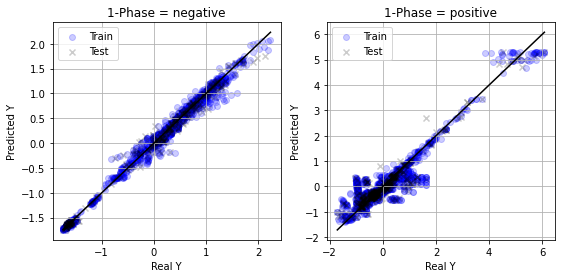

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_s_0, y_train_pred_0, alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_s_0, y_test_pred_0, alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_s_0.min(), y_train_s_0.max()], [y_train_s_0.min(), y_train_s_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_s_1, y_train_pred_1, alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_s_1, y_test_pred_1, alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_s_1.min(), y_train_s_1.max()], [y_train_s_1.min(), y_train_s_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [56]:
rmse_sum_0['GP'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['GP'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['GP'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['GP'] = [R_square_train_1, R_square_test_1] 

# **Summary**

In [57]:
summary = pd.concat([pd.DataFrame(r2_sum_0, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_0, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = negative")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.834180,0.957636,0.860171,0.999265,0.991252
Test (R square),0.857176,0.959994,0.878543,0.995627,0.989914
Train (RMSE),0.378146,0.191134,0.347248,0.025179,0.051403
Test (RMSE),0.354644,0.187696,0.327042,0.062056,0.055775


In [58]:
summary = pd.concat([pd.DataFrame(r2_sum_1, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_1, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = positive")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.207614,0.834530,0.359492,0.999146,0.902281
Test (R square),0.215638,0.820682,0.365911,0.991917,0.904294
Train (RMSE),0.489214,0.223558,0.439838,0.016061,0.171799
Test (RMSE),0.501511,0.239792,0.450918,0.050909,0.175183


# **Feature Importance**

1-Phase = negative

Text(0.5, 0, 'Feature Importance')

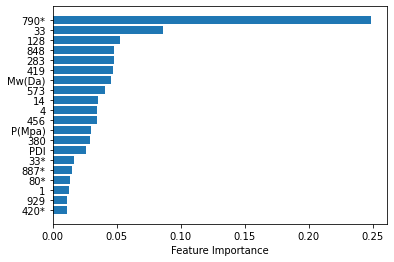

In [59]:
import matplotlib.pyplot as plt

sort = rf_0.feature_importances_.argsort()
plt.barh(f_phase0.columns[sort].astype(str)[-20:], rf_0.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

model_output = "margin" has been renamed to model_output = "raw"


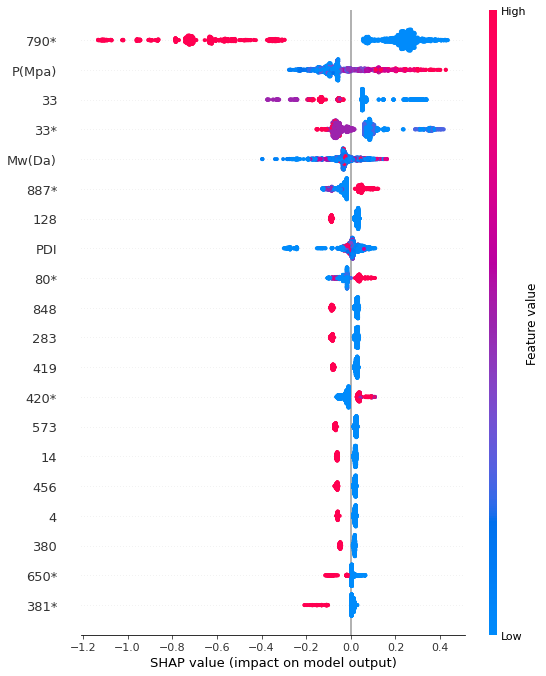

In [60]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_0, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase0)
shap.summary_plot(shap_values, f_phase0)

For Solvent
bit 790


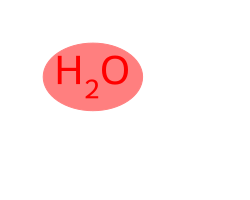

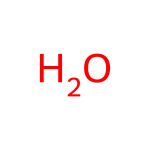

For Polymer
bit 33


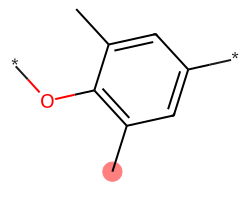

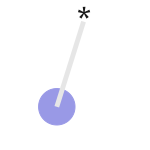

For Polymer
bit 128


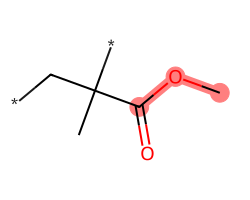

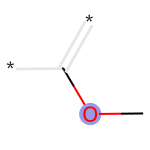

For Polymer
bit 848


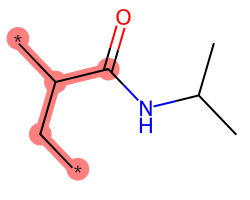

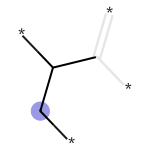

For Polymer
bit 283


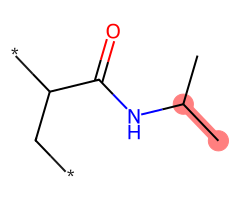

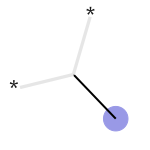

For Polymer
bit 419


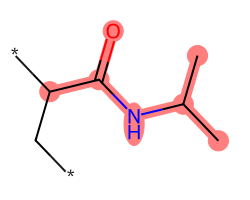

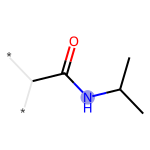

In [61]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = ["790*", 33, 128, 848, 283, 419]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

1-Phase = positive

Text(0.5, 0, 'Feature Importance')

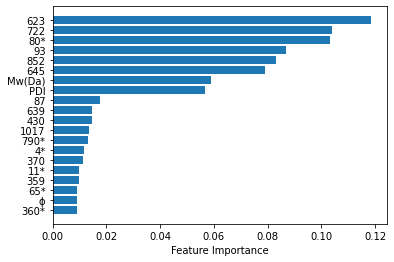

In [62]:
import matplotlib.pyplot as plt

sort = rf_1.feature_importances_.argsort()
plt.barh(f_phase1.columns[sort].astype(str)[-20:], rf_1.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

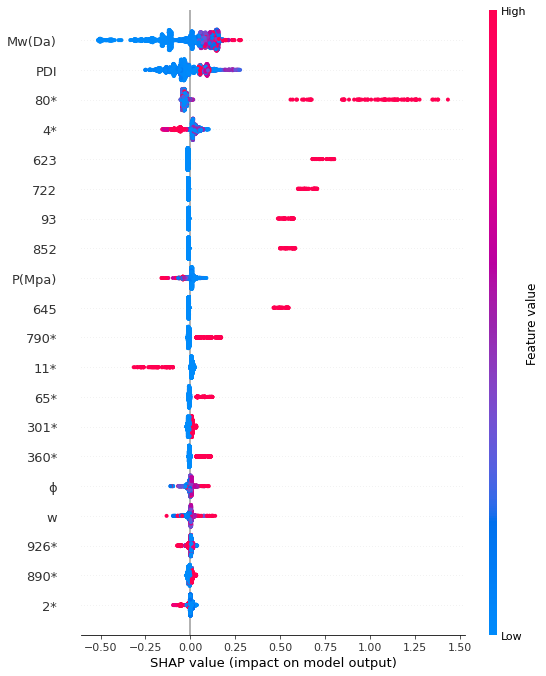

In [63]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_1, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase1)
shap.summary_plot(shap_values, f_phase1)

For Polymer
bit 623


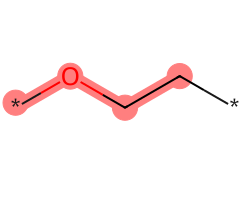

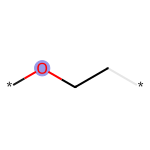

For Polymer
bit 722


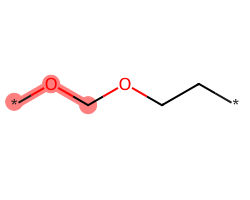

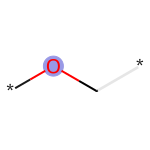

For Solvent
bit 80


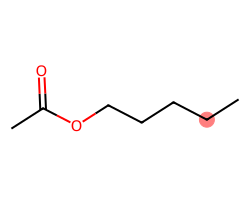

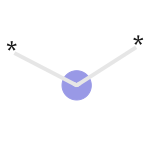

For Polymer
bit 93


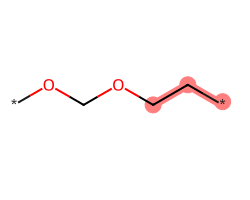

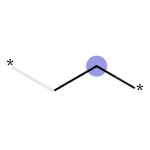

For Polymer
bit 852


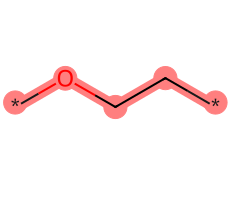

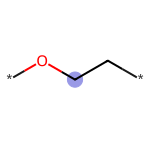

For Polymer
bit 645


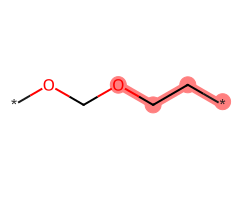

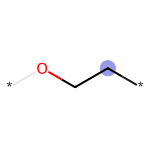

In [64]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = [623, 722, "80*", 93, 852, 645]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

Shap of GP(未完成)

In [ ]:
import shap

explainer = shap.KernelExplainer(gp, X_train)
shap_values = explainer.shap_values(X_test_tensor)
shap.summary_plot(shap_values, X_test_tensor)

Provided model function fails when applied to the provided data set.


AttributeError: ignored

# **Feature Selection未完成**

Low Variance Filter

In [ ]:
from copy import copy

thresheld = 0.1  #10%

data = copy(pd.DataFrame(X)) #only check X variables
var = data.var()
X_col = data.columns
variable = X_col[var >=thresheld] #find columns to keep
data = data[variable]

print (data.shape)

(4833, 62)


High Correlation Filter

In [ ]:
#Filter Method is the first step to perform when selecting features.
from copy import copy

thresheld = 0.8

# data = copy(fp_com) #Stacking with low variance filter
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #using 'where' and input array to choose a specific cell in dataframe
to_drop = [column for column in upper.columns if any(upper[column] >= thresheld)] #find columns to drop
data = data.drop(columns = to_drop) 

print (data.shape)

(4833, 28)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
data.to_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Training Data/Feature selected data(MF_MF_Full data).csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

X = data.values
y = df_new["CP(°C)"].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#Using randomforestregressor
rf_new = RandomForestRegressor()
rf_new.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf_new.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf_new.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf_new.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf_new.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9968371121291318
RMSE(Train): 4.330228223758278

R_square(Test): 0.9912177869152966
RMSE(Test): 7.1234415783605955


In [ ]:
rmse_sum['RF_feature selected'] = [RMSE_train, RMSE_test]
r2_sum['RF_feature selected'] = [R_square_train, R_square_test] 

Text(0.5, 0, 'Feature Importance')

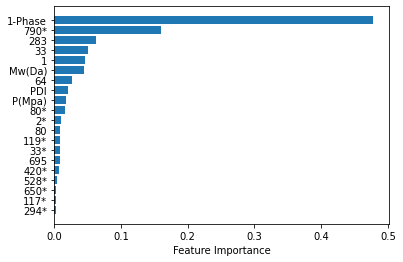

In [ ]:
sort = rf_new.feature_importances_.argsort()
plt.barh(data.columns[sort].astype(str)[-20:], rf_new.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

For Solvent
bit 790


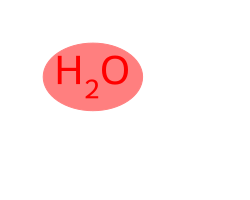

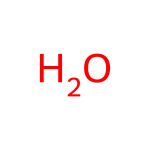

For Polymer
bit 283


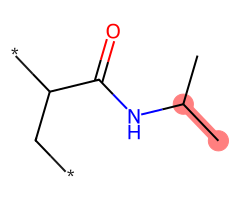

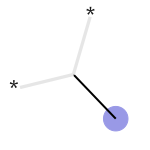

For Polymer
bit 33


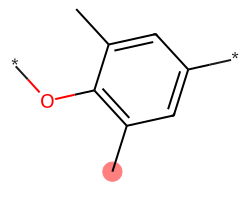

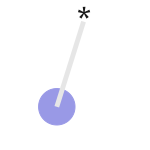

For Polymer
bit 1


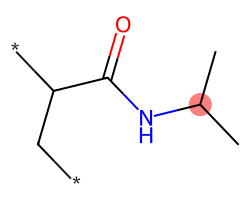

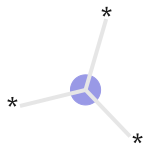

For Polymer
bit 64


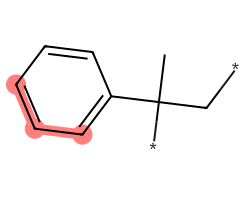

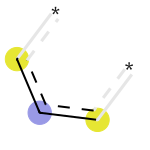

In [ ]:
#Draw top ranking Morgan fingerpirnt
from IPython.core.display import display

bits = ["790*", 283, 33, 1, 64]
for bit in bits:
  if type(bit) is int:
    print("For Polymer")
    pic1,pic2,_ = mf_poly.visualize(bit)
    display(pic1, pic2)
    
  else: 
    print("For Solvent")
    pic1,pic2,_ = mf_sol.visualize(int(bit[:-1]))
    display(pic1, pic2)

# **Bayesian Optimization未完成**

## Analytic Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(310), torch.ones(310)])

candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

print(candidate)
print(acq_value)

tensor([[0.6079, 0.1953, 0.5178, 0.5051, 0.7998, 0.8529, 0.5271, 0.0727, 0.6454,
         0.9259, 0.9154, 0.9938, 0.4107, 0.5631, 0.1763, 0.8222, 0.4232, 0.5241,
         0.2439, 0.0283, 0.5779, 0.4815, 0.7374, 0.4056, 0.4219, 0.4654, 0.1619,
         0.8422, 0.8027, 0.7063, 0.9157, 0.0380, 0.2475, 0.1264, 0.1566, 0.6084,
         0.6828, 0.0991, 0.6402, 0.1795, 0.2289, 0.7653, 0.0036, 0.3499, 0.4612,
         0.8390, 0.8910, 0.7253, 0.5783, 0.1162, 0.7685, 0.7909, 0.1302, 0.9242,
         0.8255, 0.2513, 0.8238, 0.6873, 0.2300, 0.7769, 0.6904, 0.8598, 0.2780,
         0.3449, 0.0513, 0.5832, 0.8087, 0.5754, 0.3983, 0.6823, 0.5796, 0.3681,
         0.8422, 0.5483, 0.1274, 0.5166, 0.1231, 0.6770, 0.1708, 0.8215, 0.8701,
         0.7079, 0.0578, 0.3226, 0.7066, 0.7453, 0.9357, 0.5031, 0.6489, 0.4337,
         0.6743, 0.7755, 0.8808, 0.5073, 0.6326, 0.6654, 0.3618, 0.6569, 0.7638,
         0.4405, 0.4084, 0.3459, 0.2944, 0.7386, 0.6177, 0.6475, 0.9568, 0.3197,
         0.7536, 0.7254, 0.7

## Monte-Carlo Acquisition Function

In [ ]:
from botorch.optim import optimize_acqf
from botorch.acquisition import qUpperConfidenceBound

qUCB = qUpperConfidenceBound(gp, beta=0.1)

bounds = torch.stack([torch.zeros(310), torch.ones(310)])

candidate, acq_value = optimize_acqf(
    qUCB, bounds=bounds, q=5, num_restarts=5, raw_samples=20, sequential=True
)

print(candidate)
print(acq_value)

tensor([[0.5350, 0.4567, 0.2154,  ..., 0.7444, 0.6585, 0.6162],
        [0.2426, 0.1041, 0.0904,  ..., 0.2900, 0.2782, 0.2742],
        [0.4816, 0.9507, 0.7875,  ..., 0.8367, 0.1469, 0.2812],
        [0.3732, 0.7665, 0.4030,  ..., 0.8335, 0.3265, 0.0354],
        [0.6453, 0.6621, 0.9993,  ..., 0.7832, 0.0707, 0.2988]])
tensor([0.3826, 0.5137, 0.5916, 0.6487, 0.6842], dtype=torch.float64)
